# Normal response with known true model size

In [11]:
#load packages
using IHT
using SnpArrays
using DataFrames
using Distributions
using StatsFuns: logistic
using BenchmarkTools

In [3]:
function normal_response(
    n :: Int64,   # number of cases
    p :: Int64,   # number of predictors
    k :: Int64,   # number of true predictors per group
    s :: Float64  # noise vector, from very little noise to a lot of noise
)
    #construct snpmatrix, covariate files, and true model b
    x           = SnpArray(rand(0:2, n, p))    # a random snpmatrix
    z           = ones(n, 1)                   # non-genetic covariates, just the intercept
    true_b      = zeros(p)                     # model vector
    true_b[1:k] = randn(k)                     # Initialize k non-zero entries in the true model
    shuffle!(true_b)                           # Shuffle the entries
    correct_position = find(true_b)            # keep track of what the true entries are
    noise = rand(Normal(0, s), n)              # noise

    #compute mean and std used to standardize data to mean 0 variance 1
    mean_vec, minor_allele, = summarize(x)
    update_mean!(mean_vec, minor_allele, p)
    std_vec = std_reciprocal(x, mean_vec)

    #simulate phenotypes under different noises by: y = Xb + noise
    y_temp = zeros(n)
    SnpArrays.A_mul_B!(y_temp, x, true_b, mean_vec, std_vec)
    y = y_temp + noise

    #define IHTVariable needed to run L0_reg
    v = IHTVariables(x, z, y, 1, k)
    
    #benchmark the result and return
    b = @benchmarkable L0_reg($v, $x, $z, $y, 1, $k) seconds=500 samples=10
    return run(b)
end

normal_response (generic function with 1 method)

In [7]:
function logistic_response(
    n :: Int64,   # number of cases
    p :: Int64,   # number of predictors
    k :: Int64,   # number of true predictors per group
)
    #construct snpmatrix, covariate files, and true model b
    x           = SnpArray(rand(0:2, n, p))    # a random snpmatrix
    z           = ones(n, 1)                   # non-genetic covariates, just the intercept
    true_b      = zeros(p)                     # model vector
    true_b[1:k] = randn(k)                     # Initialize k non-zero entries in the true model
    shuffle!(true_b)                           # Shuffle the entries
    correct_position = find(true_b)            # keep track of what the true entries are

    #compute mean and std used to standardize data to mean 0 variance 1
    mean_vec, minor_allele, = summarize(x)
    update_mean!(mean_vec, minor_allele, p)
    std_vec = std_reciprocal(x, mean_vec)

    #simulate phenotypes
    y_temp = zeros(n)
    SnpArrays.A_mul_B!(y_temp, x, true_b, mean_vec, std_vec)
    
    # Apply inverse logit link to map y to {0, 1} 
    y = logistic.(y_temp)  #inverse logit link
    hi = rand(length(y))
    y = Float64.(hi .< y)  #map y to 0, 1

    #define IHTVariable needed to run L0_reg
    v = IHTVariables(x, z, y, 1, k)
    
    #benchmark the result and return
    b = @benchmarkable L0_logistic_reg($v, $x, $z, $y, 1, $k, glm = "logistic") seconds=1500 samples=10
    return run(b)
end

logistic_response (generic function with 1 method)

In [ ]:
function poisson_response(
    n :: Int64,   # number of cases
    p :: Int64,   # number of predictors
    k :: Int64,   # number of true predictors per group
)
    #construct snpmatrix, covariate files, and true model b
    x           = SnpArray(rand(0:2, n, p))    # a random snpmatrix
    z           = ones(n, 1)                   # non-genetic covariates, just the intercept
    true_b      = zeros(p)                     # model vector
    true_b[1:k] = randn(k)                     # Initialize k non-zero entries in the true model
    shuffle!(true_b)                           # Shuffle the entries
    correct_position = find(true_b)            # keep track of what the true entries are

    #compute mean and std used to standardize data to mean 0 variance 1
    mean_vec, minor_allele, = summarize(x)
    update_mean!(mean_vec, minor_allele, p)
    std_vec = std_reciprocal(x, mean_vec)

    #simulate phenotypes
    y_temp = zeros(n)
    SnpArrays.A_mul_B!(y_temp, x, true_b, mean_vec, std_vec)
    
    # Apply inverse log link and sample from poisson distribution with given mean
    y = zeros(n)
    y_temp = exp.(y_temp)
    for i in 1:n
        dist = Poisson(y_temp[i])
        y[i] = rand(dist)
    end

    #define IHTVariable needed to run L0_reg
    v = IHTVariables(x, z, y, 1, k)
    
    #benchmark the result and return
    b = @benchmarkable L0_poisson_reg($v, $x, $z, $y, 1, $k, glm = "poisson") seconds=1000 samples=10
    return run(b)
end

# Benchmark Normal response on 10 sample size

In [8]:
#set random seed
srand(2018) 

#how many different sample sizes to run?
num_samples = 10

#problem dimension?
samples = [1000i for i in 1:num_samples]
p = 100000
k = 10
s = 0.1

#benchmark result on each sample size and store benchmark result
normal_result = Vector{BenchmarkTools.Trial}(num_samples)
for i in 1:length(samples)
     normal_result[i] = normal_response(samples[i], p, k, s)
end

# Benchmark Logistic response on 10 sample size

In [ ]:
#set random seed
srand(2018) 

#how many different sample sizes to run?
num_samples = 10

#problem dimension?
samples = [1000i for i in 1:num_samples]
p = 100000
k = 10
s = 0.1

#benchmark result on each sample size and store benchmark result
logistic_result = Vector{BenchmarkTools.Trial}(num_samples)
for i in 1:length(samples)
     logistic_result[i] = logistic_response(samples[i], p, k)
end

# Benchmark Poisson response on 10 sample size

In [ ]:
#set random seed
srand(2018) 

#how many different sample sizes to run?
num_samples = 10

#problem dimension?
samples = [1000i for i in 1:num_samples]
p = 100000
k = 10
s = 0.1

#benchmark result on each sample size and store benchmark result
poisson_result = Vector{BenchmarkTools.Trial}(num_samples)
for i in 1:length(samples)
     poisson_result[i] = logistic_response(samples[i], p, k)
end

# save results into vectors

In [2]:
using Plots, Plots.PlotMeasures

In [4]:
sample_size     = collect(1000:1000:10000)
normal_memory   = zeros(length(sample_size))
logistic_memory = zeros(length(sample_size))
poisson_memory  = zeros(length(sample_size))
normal_speed    = zeros(length(sample_size))
logistic_speed  = zeros(length(sample_size))
poisson_speed   = zeros(length(sample_size))

#convert memory from bytes to megabytes, speed from nanoseconds to seconds
for i in 1:length(sample_size)
    normal_memory[i]   = normal_result[i].memory / 1e6
    logistic_memory[i] = logistic_result[i].memory / 1e6
    poisson_memory[i]  = poisson_result[i].memory / 1e6
    normal_speed[i]    = median(normal_result[i].times) / 1e9
    logistic_speed[i]  = median(logistic_result[i].times) / 1e9
    poisson_speed[i]   = median(poisson_result[i].times) / 1e9
end

10-element Array{Int64,1}:
  1000
  2000
  3000
  4000
  5000
  6000
  7000
  8000
  9000
 10000

# Plot memory and speed plot side by side

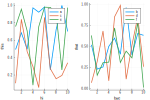

In [3]:
#test case
plot(rand(10, 6), layout = 2, xlabel = ["hi" "bye"], ylabel = ["this" "that"],
     w = 3, lab = ["a" "b" "c" "d" "e" "f"])

In [21]:
#data below were run in terminal and copy-pasted here
sample_size = collect(1000:1000:10000)
normal_speed = [5.524; 8.657; 12.089; 15.44; 19.168; 23.092; 24.176; 27.542; 35.264; 38.52]
normal_memory = [22937936; 12304752; 10683728; 9870096; 10739024; 11552528; 12381008; 11574224; 10781168; 10891792] / 1e6
logistic_speed = [26.229; 32.673; 46.688; 42.985; 51.277; 67.323; 68.769; 107.451; 92.306; 198.385]
logistic_memory = [116572400; 61533856; 66542992; 51009664; 55631504; 74373008; 82124912; 129647504; 91283408; 236299264] / 1e6
poisson_speed = [34.302; 35.441; 28.682; 51.205; 57.349; 141.958; 104.238; 100.124; 130.487; 121.762]
poisson_memory = [137788976; 65804048; 41866320; 80440912; 68735024; 169755536; 116166624; 105885040; 157520000; 159879856] / 1e6

10-element Array{Float64,1}:
 137.789 
  65.804 
  41.8663
  80.4409
  68.735 
 169.756 
 116.167 
 105.885 
 157.52  
 159.88  

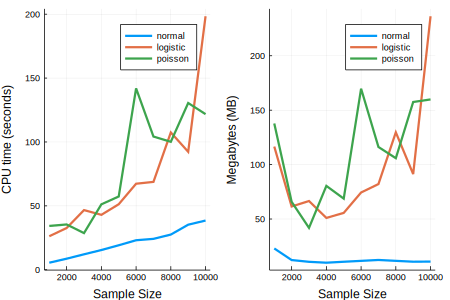

In [28]:
plt = plot(sample_size, [normal_speed normal_memory logistic_speed logistic_memory poisson_speed poisson_memory], 
    layout = 2, xlabel = ["Sample Size" "Sample Size"], ylabel = ["CPU time (seconds)" "Memory usage (MB)"], 
    w=3, lab = ["normal" "normal" "logistic" "logistic" "poisson" "poisson"], dpi=300)

In [ ]:
#save the result
savefig(plt, "speed_mem_benchmark.png")

# Now create plot for cross validation

In [ ]:
############## NORMAL CROSS VALIDATION SIMULATION
using IHT
using SnpArrays
using DataFrames
using Distributions

#set random seed
srand(123) 

#specify dimension and noise of data
n = 2000                        # number of cases
p = 10000                       # number of predictors
k = 10                          # number of true predictors per group
s = 0.1                         # noise vector, from very little noise to a lot of noise

#construct snpmatrix, covariate files, and true model b
x           = SnpArray(rand(0:2, n, p))    # a random snpmatrix
z           = ones(n, 1)                   # non-genetic covariates, just the intercept
true_b      = zeros(p)                     # model vector
true_b[1:k] = randn(k)                     # Initialize k non-zero entries in the true model
shuffle!(true_b)                           # Shuffle the entries
correct_position = find(true_b)            # keep track of what the true entries are
noise = rand(Normal(0, s), n)              # noise vectors from N(0, s) where s ∈ S = {0.01, 0.1, 1, 10}s

#compute mean and std used to standardize data to mean 0 variance 1
mean_vec, minor_allele, = summarize(x)
for i in 1:p
    minor_allele[i] ? mean_vec[i] = 2.0 - 2.0mean_vec[i] : mean_vec[i] = 2.0mean_vec[i]
end
std_vec = std_reciprocal(x, mean_vec)

#simulate phenotypes under different noises by: y = Xb + noise
y_temp = zeros(n)
SnpArrays.A_mul_B!(y_temp, x, true_b, mean_vec, std_vec)
y = y_temp += noise

#specify path and folds
path = collect(1:20)
num_folds = 5
folds = rand(1:num_folds, size(x, 1))

#compute cross validation
cv_iht(x, z, y, 1, path, folds, num_folds, use_maf = false, glm = "normal")

In [ ]:
########### LOGISTIC CROSS VALIDATION SIMULATION CODE##############
using IHT
using SnpArrays
using DataFrames
using Distributions
using StatsFuns: logistic
using BenchmarkTools

#set random seed
srand(123) 

#specify dimension and noise of data
n = 5000                        # number of cases
p = 10000                       # number of predictors
k = 10                          # number of true predictors per group
# s = 0.1                         # noise vector, from very little noise to a lot of noise

#construct snpmatrix, covariate files, and true model b
x           = SnpArray(rand(0:2, n, p))    # a random snpmatrix
z           = ones(n, 1)                   # non-genetic covariates, just the intercept
true_b      = zeros(p)                     # model vector
true_b[1:k] = randn(k)                     # Initialize k non-zero entries in the true model
shuffle!(true_b)                           # Shuffle the entries
correct_position = find(true_b)            # keep track of what the true entries are
# noise = rand(Normal(0, s), n)              # noise vectors from N(0, s) where s ∈ S = {0.01, 0.1, 1, 10}s

#compute mean and std used to standardize data to mean 0 variance 1
mean_vec, minor_allele, = summarize(x)
for i in 1:p
    minor_allele[i] ? mean_vec[i] = 2.0 - 2.0mean_vec[i] : mean_vec[i] = 2.0mean_vec[i]
end
std_vec = std_reciprocal(x, mean_vec)

#simulate phenotypes under different noises by: y = Xb + noise
y_temp = zeros(n)
SnpArrays.A_mul_B!(y_temp, x, true_b, mean_vec, std_vec)

# Apply inverse logit link to map y to {0, 1} 
y = logistic.(y_temp)               #inverse logit link
hi = rand(length(y))
y = Float64.(hi .< y)  #map y to 0, 1

#specify path and folds
path = collect(1:20)
num_folds = 5
folds = rand(1:num_folds, size(x, 1))

#compute cross validation
cv_iht(x, z, y, 1, path, folds, num_folds, use_maf = false, glm = "logistic")

# Now create plot of MSE

In [11]:
# below data was run in terminal and copy-pasted here
model_sizes  = collect(1:20)
normal_mse   = [1.9549723471377323; 1.2640590859005163; 0.9206731563502192; 0.536252062747886; 0.39326834631059365;
                0.28217492344143547; 0.1612554115380683; 0.09231947602048143; 0.04287159133590387; 0.022244162967656793;
                0.022288513387423204; 0.022342915673097614; 0.0223761299182678; 0.02242383768391249; 0.02246651684370487;
                0.022508951705979063; 0.02254754067775516; 0.02257236850020866; 0.022609046632609903; 0.022647546029875516]
logistic_mse = [0.07540466287026724; 0.06488589298509327; 0.061732302569342014; 0.05656313063857292; 0.05567172505083186;
                0.05392645992119938; 0.052710167295698954; 0.052299200883517326; 0.05161280463213389; 0.05180347764251734;
                0.0527811458015377; 0.05394690861365185; 0.05528879625976886; 0.056226023820659984; 0.05553761077038162;
                0.056648332984161734; 0.055592670258634125; 0.05806945231724564; 0.05894400844247374; 0.05896768619328714]

20-element Array{Float64,1}:
 0.0754047
 0.0648859
 0.0617323
 0.0565631
 0.0556717
 0.0539265
 0.0527102
 0.0522992
 0.0516128
 0.0518035
 0.0527811
 0.0539469
 0.0552888
 0.056226 
 0.0555376
 0.0566483
 0.0555927
 0.0580695
 0.058944 
 0.0589677

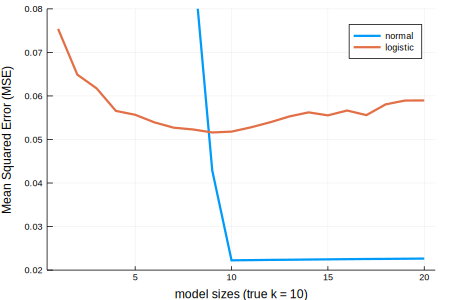

In [21]:
plt2 = plot(model_sizes, [normal_mse logistic_mse], ylims = (0.02, 0.08), w=3, lab=["normal" "logistic"], 
    xlabel="model sizes (true k = 10)", ylabel="Mean Squared Error (MSE)", dpi=300)

In [22]:
#save the result
savefig(plt2, "mse.png")